## Overview

In this notebook, we will be tackling classification using the MNISt dataset.
First Let's import the data from Scikit learn library

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

e:\programming\AI\Machine-Learning-Projects\Project1\Lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Let's have a look at the target and data arrays to see what they contain:

In [2]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

There are 70,000 images, and each image has 784 features. so each image is 28x28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

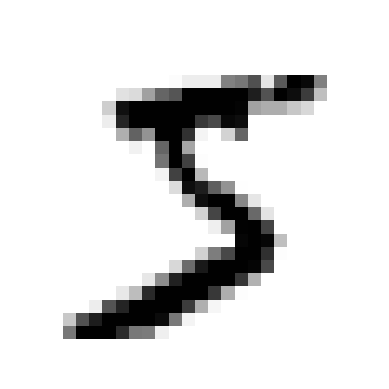

In [4]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

X= np.array(X)
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [5]:
y[0]

'5'

Since most values are expected to be integers so we can reduce size of y labels

In [6]:
y = y.astype(np.uint8)

The MNIST dataset is actually already split into a training set (the first 60,000
images) and a test set (the last 10,000 images):


In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 1-Training a Binary Classifier


Let’s simplify the problem for now and only try to identify one digit—for example,
the number 5

In [8]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

Now let pick a model and train it on the data . we will be using a Stochastic Gradi‐
ent Descent (SGD) classifier. it has the property of ealing with large datasets effiecently

In [9]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5:

In [10]:
sgd_clf.predict([some_digit])


array([ True])

## 2-Performance Measures


### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use cross-validation.Let’s use the cross_val_score() with 3 folds.

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

let's compare the results with a dumb model that returns 0 every single time

In [12]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
 def fit(self, X, y=None):
    return self
 def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

It's so closee !!! that's sus, that's demonstrate that accuracy is not always a good startegy to evaluate your model performance

### Confusion Matrix


To compute the confusion matrix, we first need to have a set of predictions so that
they can be compared to the actual targets. let's do that using the following code:

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)


array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

A perfect classifier would have only true positives and true
negatives, so its confusion matrix would have nonzero values only on its main diago‐
nal (top left to bottom right):

In [16]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

The precesion (precision = TP/(TP + FP)) is one of the metrics that we can extract from the confusion matrix . it represents the propotion of true positives predicted of all the positives predicted. Having a perfect precision means in other terms predicting only 1 label and that's prediction is true 1/1= 100%. but that's not interesting that why we have another metric called recall. it actually represents the propotion of true positive predicted from all the predictions

recall = TP/(TP + FN) with TP are the true positives , FP are the false positives and FN are the false negatives!

### Precision and Recall Implementation


In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1325)

0.6511713705958311

as we can see the results aren't that promising as before !!

For that we can use another metric called The F1 metric or the harmonic mean that combines both precision and recall such as :


F1=2 * prec *recall/(prec + recall)

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. Which is not we want for all cases , sometimes we want to ensure that all what predict is actually positive high precision . and sometimes we want to predict as much true positive as possible without caring about the number of actual negatives that we predicted as positive ( high recall )

### Precision/Recall Trade-off


we can use the SGDClassifier . it has a threshold so that if the number is on the right , it predicts 5 else it's not 5 . by moving the treshold the right u are increasing the precision but decreasing the recal . and that's what precision/ recall is all about ! 

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Having a threshold equal to 0 is like calling the predict() method, let's now raise the threshold:

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8000.

But now how to decide what treshold to have ! we will use cross_val_predict() function to get the scores of all instances in the training set, but this time specifying that we want to return decision scores instead of predictions:

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,method="decision_function")


We can then use those scores to calculate the precision and recall for all possible thresholds using the precision_recall_curve() function:

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

now we will plot the results !

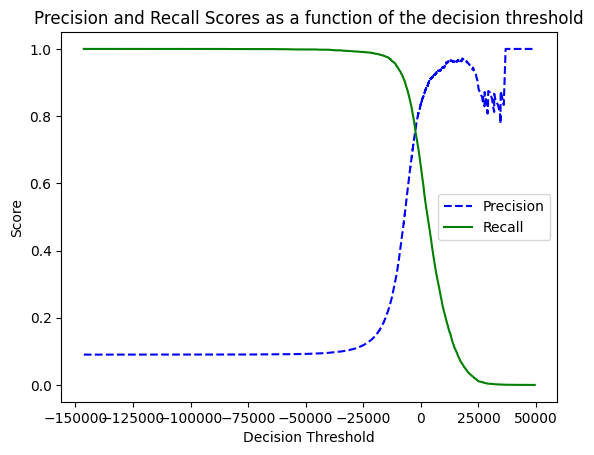

In [25]:
import matplotlib.pyplot as plt

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

# assuming precisions, recalls, thresholds are defined
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


sometimes the precision goes down when u increase the threshold, that's why it's not a good idea to select a threshold based on the precision/recall curve, you should select it based on your needs , we can use instead recall vs precision

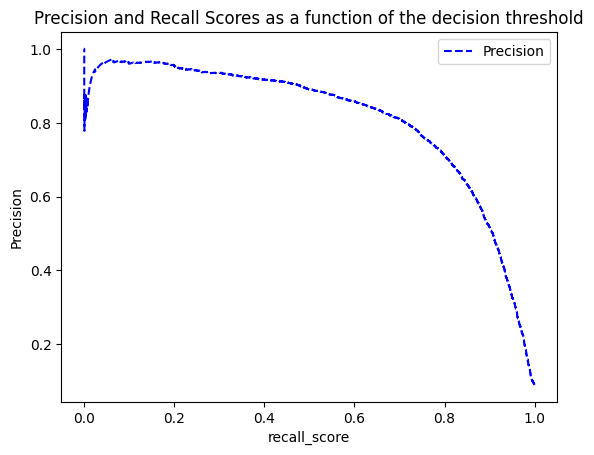

In [26]:
import matplotlib.pyplot as plt

def plot_precision_vs_recall(precisions, recalls):
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(recalls, precisions, "b--", label="Precision")
    plt.ylabel("Precision")
    plt.xlabel("recall_score")
    plt.legend(loc='best')

# assuming precisions, recalls, thresholds are defined
plot_precision_vs_recall(precisions, recalls)
plt.show()


we can create a classifier with 90% precision using the np.argmax method

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)] # ~7816

let's predict the results using the following code ! 

In [28]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

let's see the precision and recall of the result

In [29]:
precision_score(y_train_5, y_train_pred_90)

0.4799852425751706

In [30]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706